In [374]:
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, Flatten, MaxPool2D
from keras.models import Sequential
from keras.models import load_model
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import Subtract
from keras.models import Input, Model
from keras.layers import UpSampling2D
from sklearn.preprocessing import normalize

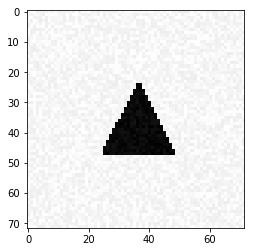

In [375]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) #np_utils. was removed
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



# 3. The SGD optimizer

In [376]:
#Generate a training set of images of simple geometric shapes (rectangle, disk, triangle) centered in the images
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [377]:
print(X_train.shape)

(300, 5184)


In [378]:
#Transform the target to categorical 
Y_train = to_categorical(Y_train)

#Choose an easy model with a linear stack of layers
model = Sequential() #no jump of layers, each node goes through all the layers

n_cols = X_train.shape[1] #find out input shape

#Dense - all the nodes from the previous layer connect to all the nodes of the following layer
model.add(Dense(72, activation='relu',  input_shape=(n_cols,)))
model.add(Dense(3, activation = 'softmax',input_shape=(n_cols,)))

#Configure it's learning process through the function compile
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', #sgd stands for Stochstic Gradient Descent
              metrics=['accuracy'])

In [379]:
#fit the model 
early_stopping = EarlyStopping(patience = 3)
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split = 0.3, callbacks = [early_stopping])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 10s 48ms/step - loss: 3.2386 - acc: 0.3381 - val_loss: 1.0808 - val_acc: 0.3444
Epoch 2/100
210/210 [==============================] - 0s 904us/step - loss: 1.0880 - acc: 0.3429 - val_loss: 1.0556 - val_acc: 0.5000
Epoch 3/100
210/210 [==============================] - 0s 819us/step - loss: 1.0457 - acc: 0.5476 - val_loss: 1.0431 - val_acc: 0.6000
Epoch 4/100
210/210 [==============================] - 0s 828us/step - loss: 1.0172 - acc: 0.5952 - val_loss: 1.0317 - val_acc: 0.5222
Epoch 5/100
210/210 [==============================] - 0s 947us/step - loss: 0.9943 - acc: 0.6095 - val_loss: 0.9804 - val_acc: 0.6000
Epoch 6/100
210/210 [==============================] - 0s 776us/step - loss: 0.9510 - acc: 0.6238 - val_loss: 0.9403 - val_acc: 0.6222
Epoch 7/100
210/210 [==============================] - 0s 1ms/step - loss: 0.9346 - acc: 0.5857 - val_loss: 0.9136 - val_acc: 0.4778
Epoch 8/100


In [380]:
#generate testing set
[X_test, Y_test] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [381]:
#Testing the model
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

# 3. The Adam optimizer

In [382]:
#Generate a training set of images of simple geometric shapes (rectangle, disk, triangle) centered in the images
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [383]:
#Transform the target to categorical 
Y_train = to_categorical(Y_train)

#Choose an easy model with a linear stack of layers
model_adam = Sequential() #no jump of layers, each node goes through all the layers

n_cols = X_train.shape[1] #find out input shape

#Dense - all the nodes from the previous layer connect to all the nodes of the following layer
model_adam.add(Dense(72, activation='relu',  input_shape=(n_cols,)))
model_adam.add(Dense(3, activation = 'softmax'))

#Configure it's learning process through the function compile
model_adam.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [384]:
#fit the model 
model_adam.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split = 0.3, callbacks = [early_stopping])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 7s 36ms/step - loss: 3.2046 - acc: 0.3952 - val_loss: 1.3114 - val_acc: 0.3778
Epoch 2/100
210/210 [==============================] - 0s 1ms/step - loss: 1.2720 - acc: 0.5286 - val_loss: 0.8880 - val_acc: 0.6556
Epoch 3/100
210/210 [==============================] - 0s 952us/step - loss: 0.8190 - acc: 0.5619 - val_loss: 0.8533 - val_acc: 0.6667
Epoch 4/100
210/210 [==============================] - 0s 899us/step - loss: 0.6128 - acc: 0.7333 - val_loss: 0.6167 - val_acc: 0.6778
Epoch 5/100
210/210 [==============================] - 0s 942us/step - loss: 0.5117 - acc: 0.7095 - val_loss: 0.5516 - val_acc: 0.6778
Epoch 6/100
210/210 [==============================] - 0s 823us/step - loss: 0.4259 - acc: 0.8333 - val_loss: 0.4554 - val_acc: 0.8778
Epoch 7/100
210/210 [==============================] - 0s 781us/step - loss: 0.3797 - acc: 0.9476 - val_loss: 0.4495 - val_acc: 0.7667
Epoch 8/100
2

In [385]:
#An example of how to check the classifier
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

# 4 Visualization of the solution

In [386]:
#Visualization of the solution with the adam optimizer
visu = model_adam.get_weights()[0]

#Divide the weights to vizualise each column as an image
array_1 = visu[:,0]
array_2 = visu[:,1]
array_3 = visu[:,2]

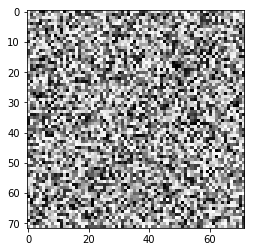

In [387]:
#Visualize the first column
plt.imshow(array_1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys)
plt.show()

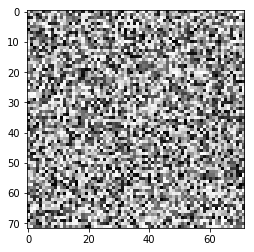

In [388]:
#Visualize the second column
plt.imshow(array_2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys)
plt.show()

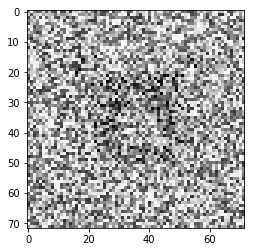

In [389]:
#Visualize the third column
plt.imshow(array_3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap = cm.Greys)
plt.show()

# 5. A more difficult classification problem

In [390]:
#Generate the training set
[X_train, Y_train] = generate_dataset_classification(750, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740


In [391]:
print(X_train.shape)

(750, 5184)


In [392]:
#Reshape the data
X_train = X_train.reshape([-1,72,72,1])
print(X_train.shape)
n_cols = X_train.shape[1] 
n_rows = X_train.shape[2]
print(n_cols, n_rows)

(750, 72, 72, 1)
72 72


In [393]:
#Transform the target to categorical 
Y_train = to_categorical(Y_train)

#Initialise the model
model_conv = Sequential() 

#Add a convolutional layer
model_conv.add(Conv2D(16, kernel_size = 5, activation='relu',  input_shape = (n_cols,n_rows,1)))

#Add a pooling layer
model_conv.add(MaxPool2D(2))

#Add a second convolutional layer
model_conv.add(Conv2D(16, kernel_size = 5, activation='relu'))

#Add a second pooling layer
model_conv.add(MaxPool2D(2))

model_conv.add(Flatten()) #Connect convolutional layer to dense layer

model_conv.add(Dense(3, activation = 'softmax')) #Output layer

#Configure it's learning process through the function compile
model_conv.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [394]:
#fit the model 
early_stopping = EarlyStopping(patience = 2)
model_conv.fit(X_train, Y_train, epochs=100, batch_size = 32,validation_split = 0.3, callbacks = [early_stopping])
model_conv.summary()

Train on 525 samples, validate on 225 samples
Epoch 1/100
525/525 [==============================] - 12s 24ms/step - loss: 1.0817 - acc: 0.4171 - val_loss: 1.0863 - val_acc: 0.5111
Epoch 2/100
525/525 [==============================] - 4s 8ms/step - loss: 0.9396 - acc: 0.6057 - val_loss: 0.8515 - val_acc: 0.7022
Epoch 3/100
525/525 [==============================] - 4s 8ms/step - loss: 0.7554 - acc: 0.7086 - val_loss: 0.7605 - val_acc: 0.6622
Epoch 4/100
525/525 [==============================] - 4s 8ms/step - loss: 0.6449 - acc: 0.7371 - val_loss: 0.6378 - val_acc: 0.7733
Epoch 5/100
525/525 [==============================] - 4s 8ms/step - loss: 0.5559 - acc: 0.8038 - val_loss: 0.6327 - val_acc: 0.7511
Epoch 6/100
525/525 [==============================] - 4s 8ms/step - loss: 0.5385 - acc: 0.8000 - val_loss: 0.6801 - val_acc: 0.7111
Epoch 7/100
525/525 [==============================] - 5s 9ms/step - loss: 0.5242 - acc: 0.8095 - val_loss: 0.6111 - val_acc: 0.7556
Epoch 8/100
525/525 [

In [395]:
#Generate test set
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [396]:
#Reshape the data
X_test = X_test.reshape([-1,72,72,1])

#Evaluate test set
model_conv.evaluate(X_test, Y_test)

300/300 [==============================] - 2s 6ms/step


[0.5285780866940816, 0.7999999992052714]

# 6. A Regression Problem

In [333]:
[X_train, Y_train] = generate_dataset_regression(500, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


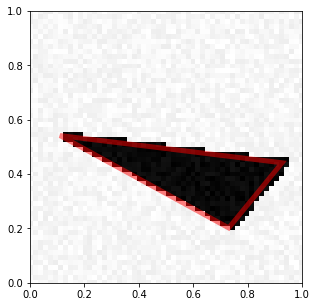

In [334]:
visualize_prediction(X_train[0], Y_train[0])

In [353]:
#Reshape X_train
X_train = X_train.reshape([-1, 72,72,1])

#Here several different combinations of neurons/layers were tried 
model_r = Sequential() #Initialise the model
model_r.add(Conv2D(32, kernel_size = 5, activation='relu',  input_shape = (72,72,1)))
model_r.add(MaxPooling2D(2))
model_r.add(Conv2D(16, kernel_size = 5, activation='relu',  input_shape = (72,72,1)))
model_r.add(MaxPool2D(2))
model_r.add(Conv2D(16, kernel_size = 5, activation='relu',  input_shape = (72,72,1)))
#model_r.add(Conv2D(16, kernel_size = 5, activation='relu',  input_shape = (72,72,1)))
model_r.add(Flatten())
#model_r.add(Dense(16, activation = 'relu')) #,input_dim = X_train.shape[1]))
#model_r.add(Dense(16, activation = 'relu'))
#model_r.add(BatchNormalization()) #Batch normalize
#model_r.add(Dropout(0.2))
model_r.add(Dense(6,)) #output layer


model_r.compile(loss='mean_squared_error',  optimizer='adam', metrics=['mean_absolute_error'])

In [354]:
Y_train = normalize(Y_train)

In [355]:
training = model_r.fit(X_train, Y_train, epochs = 10, batch_size = 32)#, validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/10
500/500 [==============================] - 16s 33ms/step - loss: 0.0604 - mean_absolute_error: 0.3401
Epoch 2/10
500/500 [==============================] - 6s 13ms/step - loss: 0.0517 - mean_absolute_error: 0.2956
Epoch 3/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0505 - mean_absolute_error: 0.3109
Epoch 4/10
500/500 [==============================] - 6s 12ms/step - loss: 0.0499 - mean_absolute_error: 0.3127
Epoch 5/10
500/500 [==============================] - 6s 12ms/step - loss: 0.0377 - mean_absolute_error: 0.2628
Epoch 6/10
500/500 [==============================] - 6s 12ms/step - loss: 0.0345 - mean_absolute_error: 0.2360
Epoch 7/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0334 - mean_absolute_error: 0.2272
Epoch 8/10
500/500 [==============================] - 7s 14ms/step - loss: 0.0328 - mean_absolute_error: 0.2304
Epoch 9/10
500/500 [==============================] - 6s 13ms/step - loss: 0.0321 - mean_absolute_error

In [356]:
#Plot te loss function of the training set vs the validation set see if the model is overfitting
#plt.plot(training.history['loss'])
#plt.plot(training.history['val_loss'])
#plt.show()

In [357]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [358]:
#Reshape X_test and normalize Y_test
X_test = X_test.reshape([-1, 72,72,1])
Y_test = normalize(Y_test)

In [359]:
#Predict and normalize
y_pred = model_r.predict(X_test)
y_pred = normalize(y_pred)

In [360]:
#Evaluate the model
model_r.evaluate(X_test, Y_test)

300/300 [==============================] - 2s 8ms/step


[0.035122608145078026, 0.23506258348623912]

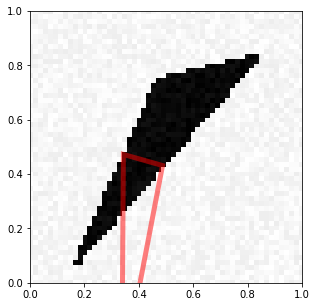

In [373]:
#Visualise the prediction
visualize_prediction(X_test[100], y_pred[100])

# 7 Image Denoising

In [177]:
#Generate pair of images, one with noise and one without
def generate_a_drawing_n(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_n = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_n, imdata

def generate_a_rectangle_n(free_location=False):
    noise = np.random.randint(0,100) #Make some noise
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_n(figsize, U, V, noise)


def generate_a_disk_n(free_location=False):
    noise = np.random.randint(0,100) #Make some noise
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_n(figsize, U, V, noise)

def generate_a_triangle_n(free_location=False):
    noise = np.random.randint(0,100) #Make some noise
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing_n(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification_n(nb_samples, free_location=False):
    noise = np.random.randint(0,100) #Make some noise
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,2,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle_n(free_location)
        elif category == 1: 
            X[i] = generate_a_disk_n(free_location)
        else:
            [X[i], V] = generate_a_triangle_n(free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [194]:
#Generate the training set
training, same = generate_dataset_classification_n(1000)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [195]:
#Divide into training and testing 
X_train = training[:,0]
Y_train = training[:,1]

#Reshape to 4 dimensions
X_train = X_train.reshape(-1, 72,72,1)
Y_train = Y_train.reshape(-1, 72,72,1)

In [207]:
#Construct the model with several convolution and pooling layers
rip = Input(shape=(72, 72, 1))

temp = Conv2D(32, (3, 3), activation='relu', padding='same')(rip)
temp = MaxPooling2D((2, 2), padding='same')(temp)
temp = Conv2D(32, (3, 3), activation='relu', padding='same')(temp)
temp = MaxPooling2D((2, 2), padding='same')(temp)
temp = Conv2D(32, (3, 3), activation='relu', padding='same')(temp)
temp = UpSampling2D((2, 2))(temp)
temp = Conv2D(32, (3, 3), activation='relu', padding='same')(temp)
temp = UpSampling2D((2, 2))(temp)

output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(temp)

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 33s 41ms/step - loss: 0.6723 - val_loss: 0.6108
Epoch 2/30
800/800 [==============================] - 23s 29ms/step - loss: 0.5934 - val_loss: 0.5932
Epoch 3/30
800/800 [==============================] - 24s 31ms/step - loss: 0.5863 - val_loss: 0.5730
Epoch 4/30
800/800 [==============================] - 23s 29ms/step - loss: 0.5736 - val_loss: 0.5659
Epoch 5/30
800/800 [==============================] - 22s 28ms/step - loss: 0.5613 - val_loss: 0.5538
Epoch 6/30
800/800 [==============================] - 24s 30ms/step - loss: 0.5479 - val_loss: 0.5357
Epoch 7/30
800/800 [==============================] - 27s 34ms/step - loss: 0.5283 - val_loss: 0.5116
Epoch 8/30
800/800 [==============================] - 30s 38ms/step - loss: 0.5067 - val_loss: 0.4953
Epoch 9/30
800/800 [==============================] - 24s 30ms/step - loss: 0.4921 - val_loss: 0.4839
Epoch 10/30
800/800 [===============

In [ ]:
#Compile and fit the model
model_denoising = Model(rip, output)
model_denoising.compile(optimizer="adam", loss='binary_crossentropy')
model_denoising.fit(X_train, Y_train, epochs=20, batch_size=128,validation_split=0.2, callbacks = [early_stopping])

In [208]:
#generate test set
testing, same = generate_dataset_classification_n(5, 20)

Creating data:
0


In [ ]:
#prepare test set and reshape
X_test = testing[:,0]
Y_test = testing[:,1]
X_test = X_test.reshape(-1,72,72,1)
Y_test = Y_test.reshape(-1,72,72,1)

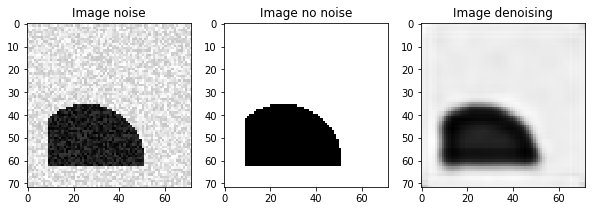

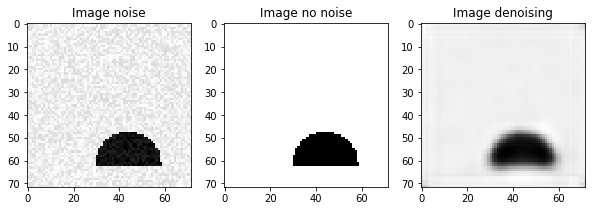

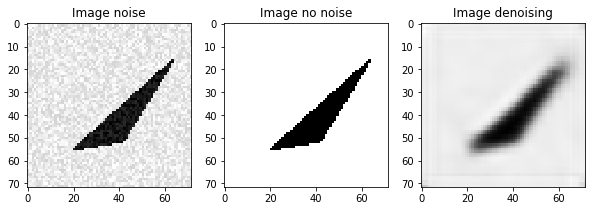

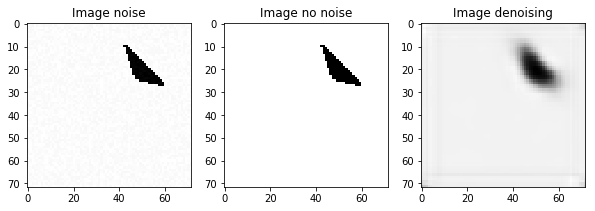

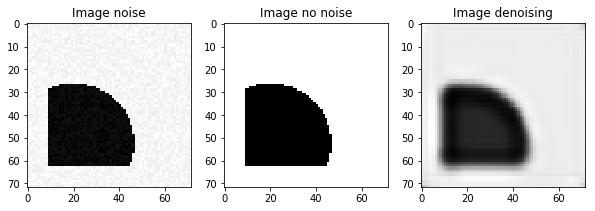

In [209]:
#Plot the images
for j in range(5):
  fig = plt.figure(figsize = (10,20))
  fig.tight_layout()
    
  ax = plt.subplot(1, 3, 1)
  plt.imshow(X_test[j].reshape((72,72)),cmap='gray')
  plt.title("Image noise")

  ax = plt.subplot(1, 3, 2)
  plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')
  plt.title("Image no noise")

  ax = plt.subplot(1, 3, 3)
  plt.imshow((model_denoising.predict(X_test[j].reshape((-1,72,72,1)))).reshape((72,72)),cmap='gray')
  plt.title("Image denoising")

